In [0]:
# TensorFlow Tutorials
# ML basics with Keras 
# Text classification with preprocessed text
# https://www.tensorflow.org/tutorials/keras/text_classification
# tfds.load: https://www.tensorflow.org/datasets/api_docs/python/tfds/load
# more advanced text classification tutorial: https://developers.google.com/machine-learning/guides/text-classification/
# To encode your own text, use tokenizer. Tutorial: https://www.tensorflow.org/tutorials/load_data/text
# imdb tfds dataset: https://www.tensorflow.org/datasets/catalog/imdb_reviews
# TF Hub (Transfer Learning): https://www.tensorflow.org/hub
  # https://tfhub.dev/s?module-type=text-embedding

# TF Keras Embedding: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
# TF Hub Keraslayer: https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer
# TF Keras regularizers: https://keras.io/api/layers/regularizers/    https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
# TF Keras Cnv1D: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D
# TF Keras LSTM: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

# Live training plots: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e



import tensorflow as tf
print(tf.__version__)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from datetime import *

!pip install -q tensorflow-Hub
!pip install -q tfds-nightly

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")


starttime = datetime.now()


# Download the IMDB dataset:
# The IMDB movie reviews dataset comes packaged in tfds. It has already been preprocessed so that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.
# The following code downloads the IMDB dataset to your machine (or uses a cached copy if you've already downloaded it):
# To encode your own text see the Loading text tutorial: https://www.tensorflow.org/tutorials/load_data/text
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    # split = (tfds.Split.TRAIN, tfds.Split.TEST),
    split=('train', 'test'),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)


print('\n')


# Try the encoder
# The dataset info includes the text encoder (a tfds.features.text.SubwordTextEncoder).
encoder = info.features['text'].encoder
print(encoder.subwords[:20])
print('Vocabulary size: {}'.format(encoder.vocab_size))


print('\n')


# This text encoder will reversibly encode any string:
sample_string = 'Hello Tensorflow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string: {}'.format(encoded_string))

decoded_string = encoder.decode(encoded_string)
print('Decoded string: \'{}\''.format(decoded_string))

assert decoded_string == sample_string

# The encoder encodes the string by breaking it into subwords or characters if the word is not in its dictionary. So the more a string resembles the dataset, the shorter the encoded representation will be.
for ts in encoded_string:
  print('{} ---> {}'.format(ts, encoder.decode([ts])) )


print('\n')


# Explore the dataset:
for train_example, train_label in train_data.take(1):
  print('Encoded train example: \'{}\''.format(train_example[:10].numpy()))   # numpy() is required as data is in tensor format and can't be printed if not transformed to numpy!
  print('Train label: \'{}\''.format(train_label.numpy()))   # numpy() is required as data is in tensor format and can't be printed if not transformed to numpy!
  print('Decoded train example: \'{}\''.format(encoder.decode(train_example)))

print('\n')


# Preparing the data for training
# You will want to create batches of training data for your model. The reviews are all different lengths, so use padded_batch to zero pad the sequences while batching:
buffer_size = 10000
batch_size = 128
# Note that the dataset is already tokenized to integer vectors. So we only have to padd it:
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch
# Unlike tf.data.Dataset.batch, the input elements to be batched may have different shapes, and this transformation will pad each component to the respective shape in padded_shapes. The padded_shapes argument determines the resulting shape for each dimension of each component in an output element:
# - If the dimension is a constant, the component will be padded out to that length in that dimension.  <- when padded_shape set to some value.
# - If the dimension is unknown, the component will be padded out to the maximum length of all elements in that dimension.  <- when padded_shape set to None.
train_batches = train_data.shuffle(buffer_size).padded_batch(batch_size, padded_shapes=([None],[]))
test_batches = test_data.shuffle(buffer_size).padded_batch(batch_size, padded_shapes=([None],[]))

# Each batch will have a shape of (batch_size, sequence_length) because the padding is dynamic each batch will have a different length:
for example_batch, label_batch in train_batches.take(2):
  print('Batch shape: {}'. format(example_batch.shape))
  print('Label shape: {}'. format(label_batch.shape))


print('\n')


et1 = datetime.now() - starttime

print( '\n-> Elapsed execution time: %0.4f seconds.\n' %(et1.total_seconds()) )

2.2.0


TF Version:  2.2.0
Eager mode:  True
Hub version:  0.8.0
GPU is available


['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_']
Vocabulary size: 8185


Encoded string: [4025, 222, 6307, 2327, 2934, 7975]
Decoded string: 'Hello Tensorflow.'
4025 ---> Hell
222 ---> o 
6307 ---> Ten
2327 ---> sor
2934 ---> flow
7975 ---> .


Encoded train example: '[  62   18   41  604  927   65    3  644 7968   21]'
Train label: '0'
Decoded train example: 'This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love 

## Build the model


In [0]:

# Build a train model:
# The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, see the word embedding tutorial.
# Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(input_dim=encoder.vocab_size, output_dim=16, input_length=[]))  # input_dim = vocab size; output_dim = embedding dim; input_length = padding length
                                                                                                    # input_length: Length of input sequences, when it is constant. This argument is required if you are going to connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed). Use GlobalPool1D when padding length is not constant  !
model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=5, activation='relu')) #, strides=1, padding='causal')   # stride length of the conv; 'padding causal' results in causal (dilated) convolutions, e.g. `output[t]` does not depend on `input[t+1:]`. Useful when modeling temporal data where the model should not violate the temporal order.

# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)))
# model.add(tf.keras.layers.GlobalAveragePooling1D())   # enable if we don't use the LSTM layer! comment if we use the LSTM!

model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
# model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model.summary()

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
model.compile(
    optimizer=Adam(lr=0.01),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 8)           648       
_________________________________________________________________
bidirectional (Bidirectional (None, 16)                1088      
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 132,841
Trainable params: 132,841
Non-trainable params: 0
_________________________________________________________________


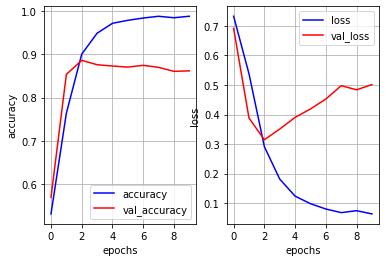

196/196 [==============================] - 76s 390ms/step - loss: 0.0632 - accuracy: 0.9884 - val_loss: 0.5015 - val_accuracy: 0.8620


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


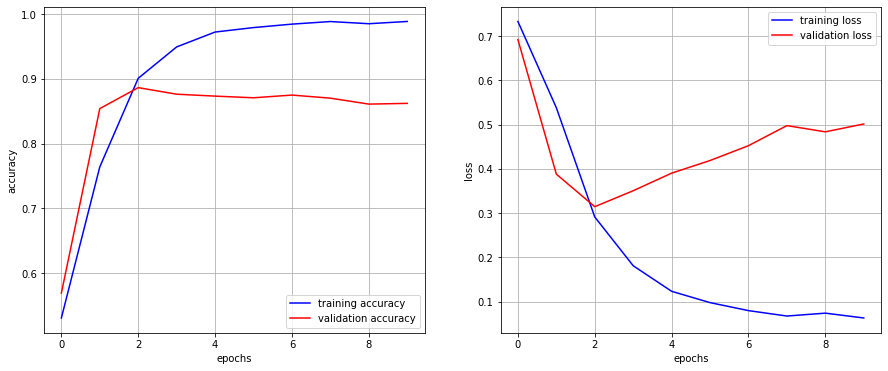



196/196 [==============================] - 22s 112ms/step - loss: 0.5014 - accuracy: 0.8618
Test accuracy: 86.18%
Test loss: 0.50%
196/196 [==============================] - 22s 111ms/step - loss: 0.5014 - accuracy: 0.8620
loss: 0.501
accuracy: 0.862


[[0.01988352]
 [0.9913965 ]
 [0.9832546 ]
 [0.00309747]
 [0.97609395]
 [0.99183536]
 [0.9967956 ]
 [0.9693755 ]
 [0.00402981]
 [0.31976327]]
test example 0, label: [0] vs prediction: [0]
test example 1, label: [0] vs prediction: [1]
test example 2, label: [1] vs prediction: [1]
test example 3, label: [1] vs prediction: [0]
test example 4, label: [0] vs prediction: [1]
test example 5, label: [1] vs prediction: [1]
test example 6, label: [0] vs prediction: [1]
test example 7, label: [0] vs prediction: [1]
test example 8, label: [1] vs prediction: [0]
test example 9, label: [0] vs prediction: [0]

-> Elapsed execution time: 869.8646 seconds.



In [0]:
starttime = datetime.now()


# Callback for training target:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        target=0.9999
        if logs['accuracy']>target :
            print('\nReached %0.2f%% training accuracy. Training converged!' %(target*100))
            self.model.stop_training = True
        
            
callback = myCallback()


# Callback for Live Training Plots:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accu = []
        self.val_accu = []
        
        self.fig = plt.figure(figsize=(15,6))
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        # self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accu.append(logs.get('accuracy'))
        self.val_accu.append(logs.get('val_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        
        plt.subplot(1,2,1)
        plt.plot(self.x, self.accu, 'b', label="accuracy")
        plt.plot(self.x, self.val_accu, 'r', label="val_accuracy")
        plt.grid()
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(self.x, self.losses, 'b', label="loss")
        plt.plot(self.x, self.val_losses, 'r', label="val_loss")
        plt.grid()
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend()

        plt.show();


plot_losses = PlotLosses()


# Train the model:
history = model.fit(
    train_batches,
    # batch_size=512,  # not needed because we batch de data with tfds .padded_batch() above
    epochs= 10,
    validation_data= test_batches,
    callbacks= [callback, plot_losses],
    verbose= 1
    )


print('\n')


# Plot the training curves:
print(history.history.keys())
loss = history.history['loss']
accu = history.history['accuracy']
val_loss = history.history['val_loss']
val_accu = history.history['val_accuracy']

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(accu, 'b', label='training accuracy')
plt.plot(val_accu, 'r', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(loss, 'b', label='training loss')
plt.plot(val_loss, 'r', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)

plt.show()


print('\n')


# Evaluate accuracy: compare how the model performs on the test dataset:
test_loss, test_accu = model.evaluate(test_batches, verbose=1)
print('Test accuracy: %0.2f%%' %(test_accu*100))
print('Test loss: %0.2f' %(test_loss))

results = model.evaluate(test_batches, verbose=1)
for name, value in zip(model.metrics_names, results):
  print('%s: %0.3f' %(name,value))


print('\n')


# Make predictions:
# predicting the labels for the test set:
predictions = model.predict(test_batches)
# prediction on 10 test examples:
print(predictions[:10])

test_examples, test_labels = next(iter(test_batches))
i = 0
for lab, pred in zip(test_labels.numpy(), predictions):
  if i<10 :
    print('test example %d, label: [%s] vs prediction: %s' %(i,lab,(pred>0.5).astype('int32')))
  else :
    break
  i+=1



et1 = datetime.now() - starttime

print( '\n-> Elapsed execution time: %0.4f seconds.\n' %(et1.total_seconds()) )